In [1]:
!pip install python-louvain


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import bibtexparser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import networkx as nx
from itertools import combinations
from community import community_louvain
from collections import Counter
import re
import numpy as np

In [134]:
# Fonction pour charger et prétraiter les données
def load_and_preprocess(file_path):
    with open(file_path, 'r', encoding='utf-8') as bibtex_file:
        bib_database = bibtexparser.load(bibtex_file)
    df = pd.DataFrame(bib_database.entries)
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    return df

# Analyse temporelle
def plot_temporal_analysis(df):
    year_counts = df['year'].value_counts().sort_index()
    plt.figure(figsize=(12, 6))
    year_counts.plot(kind='bar')
    plt.title('Nombre de publications par année')
    plt.xlabel('Année')
    plt.ylabel('Nombre de publications')
    plt.tight_layout()
    plt.savefig('temp.png')
    plt.show()

# Auteurs les plus prolifiques
def plot_top_authors(df, top_n=10):
    authors = df['author'].str.split(' and ', expand=True).stack()
    author_counts = authors.value_counts().head(top_n)
    plt.figure(figsize=(12, 6))
    author_counts.plot(kind='bar')
    plt.title(f'Top {top_n} des auteurs les plus prolifiques')
    plt.xlabel('Auteur')
    plt.ylabel('Nombre de publications')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('authors.png')
    plt.show()

# Nuage de mots-clés
def plot_keyword_cloud(df):
    all_keywords = ' '.join(df['keywords'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuage de mots-clés')
    plt.savefig('cloud.png')
    plt.show()

# Évolution des mots-clés au fil du temps
def plot_keyword_evolution(df, top_n=5):
    df['keywords'] = df['keywords'].fillna('')
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    keyword_counts = df.groupby('year')['keywords'].apply(lambda x: ' '.join(x).split(',')).apply(Counter)
    top_keywords = keyword_counts.sum().most_common(top_n)
    
    keyword_evolution = pd.DataFrame({kw: keyword_counts.apply(lambda x: x[kw]) for kw, _ in top_keywords})
    keyword_evolution.plot(figsize=(12, 6), marker='o')
    plt.title(f'Évolution des {top_n} mots-clés les plus fréquents')
    plt.xlabel('Année')
    plt.ylabel('Fréquence')
    plt.legend(title='Mots-clés', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('keyword.png')
    plt.show()

def plot_keyword_evolution(df, top_n=5):
    df['keywords'] = df['keywords'].fillna('')
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    
    def split_and_clean_keywords(keywords_string):
        return [kw.strip().lower() for kw in keywords_string.split(';') if kw.strip()]
    
    # Créer un dictionnaire pour stocker les compteurs de mots-clés par année
    keyword_counts = {}
    all_keywords = Counter()

    for year, group in df.groupby('year'):
        year_keywords = Counter(kw for keywords in group['keywords'] for kw in split_and_clean_keywords(keywords))
        keyword_counts[year] = year_keywords
        all_keywords.update(year_keywords)
    
    top_keywords = [kw for kw, _ in all_keywords.most_common(top_n)]
    
    # Créer un DataFrame pour l'évolution des top mots-clés
    keyword_evolution = pd.DataFrame({
        kw: [keyword_counts.get(year, Counter()).get(kw, 0) for year in sorted(keyword_counts.keys())]
        for kw in top_keywords
    }, index=sorted(keyword_counts.keys()))
    
    # Tracer le graphique
    plt.figure(figsize=(14, 8))
    for kw in top_keywords:
        plt.plot(keyword_evolution.index, keyword_evolution[kw], marker='o', label=kw)
    
    plt.title(f'Évolution des {top_n} mots-clés les plus fréquents')
    plt.xlabel('Année')
    plt.ylabel('Fréquence')
    plt.legend(title='Mots-clés', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('keyword.png')
    plt.show()

    # Afficher un résumé des données
    #print("Résumé de l'évolution des mots-clés:")
    #print(keyword_evolution.describe())

    #return keyword_evolution

# Analyse des co-auteurs avec sous-réseaux
def plot_coauthor_networks(df):
    def get_coauthor_pairs(authors_string):
        authors = authors_string.split(' and ') if authors_string.find(' and ') else [authors_string]
        return list(combinations(authors, 2))

    coauthor_pairs = df['author'].apply(get_coauthor_pairs).sum()
    G = nx.Graph()
    G.add_edges_from(coauthor_pairs)

    # Détection des communautés
    communities = community_louvain.best_partition(G)
    
    # Création d'un sous-graphe pour chaque communauté
    subgraphs = {}
    for com in set(communities.values()):
        nodes = [nodes for nodes in communities.keys() if communities[nodes] == com]
        subgraphs[com] = G.subgraph(nodes)

    # Identifier le plus grand sous-réseau
    largest_subgraph = max(subgraphs.values(), key=len)
    #for com, subgraph in subgraphs.items():
     #   if len(subgraph) > 1:  # Afficher seulement les sous-réseaux avec plus de 3 nœuds
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(largest_subgraph)
    nx.draw(largest_subgraph, pos, with_labels=True, node_size=1000, node_color='lightblue', 
            font_size=8)
    nx.draw_networkx_labels(largest_subgraph, pos, font_size=8)
    plt.title(f'Sous-réseau de co-auteurs {len(largest_subgraph)}')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('coauthor.png')
    plt.show()

# Analyse des citations
def plot_citation_analysis(df):
    if 'citations' in df.columns:
        df['citations'] = pd.to_numeric(df['citations'], errors='coerce')
        plt.figure(figsize=(12, 6))
        sns.histplot(df['citations'], kde=True)
        plt.title('Distribution des citations')
        plt.xlabel('Nombre de citations')
        plt.ylabel('Fréquence')
        plt.show()
    else:
        print("Les données de citation ne sont pas disponibles.")

# Journaux/Conférences les plus fréquents
def plot_top_venues(df, top_n=10):
    venue_counts = df['journal'].value_counts().head(top_n)
    plt.figure(figsize=(12, 6))
    venue_counts.plot(kind='barh')
    plt.title(f'Top {top_n} des journaux/conférences')
    plt.xlabel('Journal/Conférence')
    plt.ylabel('Nombre de publications')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_top_bible(df, top_n=10):
    def extract_acronym(booktitle):
        # Recherche une séquence de lettres majuscules entre parenthèses, 
        # suivie optionnellement par un autre ensemble de parenthèses contenant des chiffres
        if isinstance(booktitle, str):  # Vérifie si booktitle est une chaîne de caractères
            match = re.search(r'\(([A-Z]+)\)(?:\(\d+\))?', booktitle)
            if match:
                return match.group(1)
        return None  # Retourne None si booktitle n'est pas une chaîne ou si aucun match trouvé


    df['booktitle'] = df['booktitle'].apply(extract_acronym)
    venue_counts = df['booktitle'].value_counts().head(top_n)
    plt.figure(figsize=(12, 6))
    venue_counts.plot(kind='bar')
    plt.title(f'Top {top_n} des journaux/conférences')
    plt.xlabel('Journal/Conférence')
    plt.ylabel('Nombre de publications')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('bible.png')
    plt.show()



In [107]:
df = load_and_preprocess('hhh1.bib')

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        100 non-null    object
 1   doi        97 non-null     object
 2   publisher  48 non-null     object
 3   date       76 non-null     object
 4   month      76 non-null     object
 5   year       100 non-null    int64 
 6   booktitle  48 non-null     object
 7   title      100 non-null    object
 8   author     98 non-null     object
 9   ENTRYTYPE  100 non-null    object
 10  ID         100 non-null    object
 11  note       51 non-null     object
 12  pages      49 non-null     object
 13  number     39 non-null     object
 14  volume     44 non-null     object
 15  journal    52 non-null     object
dtypes: int64(1), object(15)
memory usage: 12.6+ KB


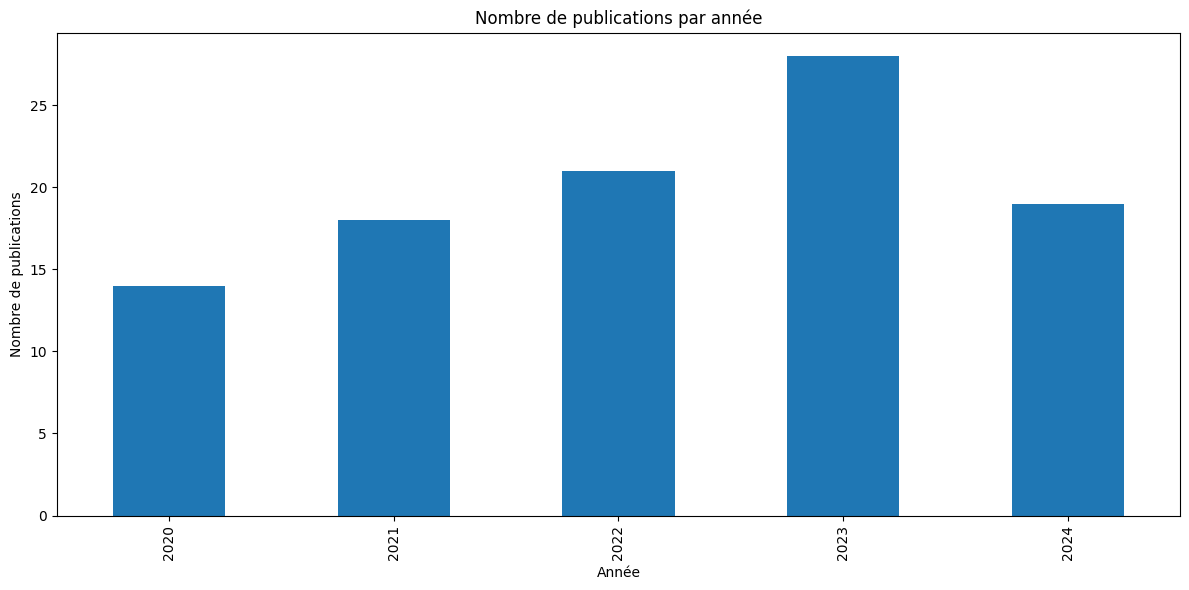

In [109]:
plot_temporal_analysis(df)

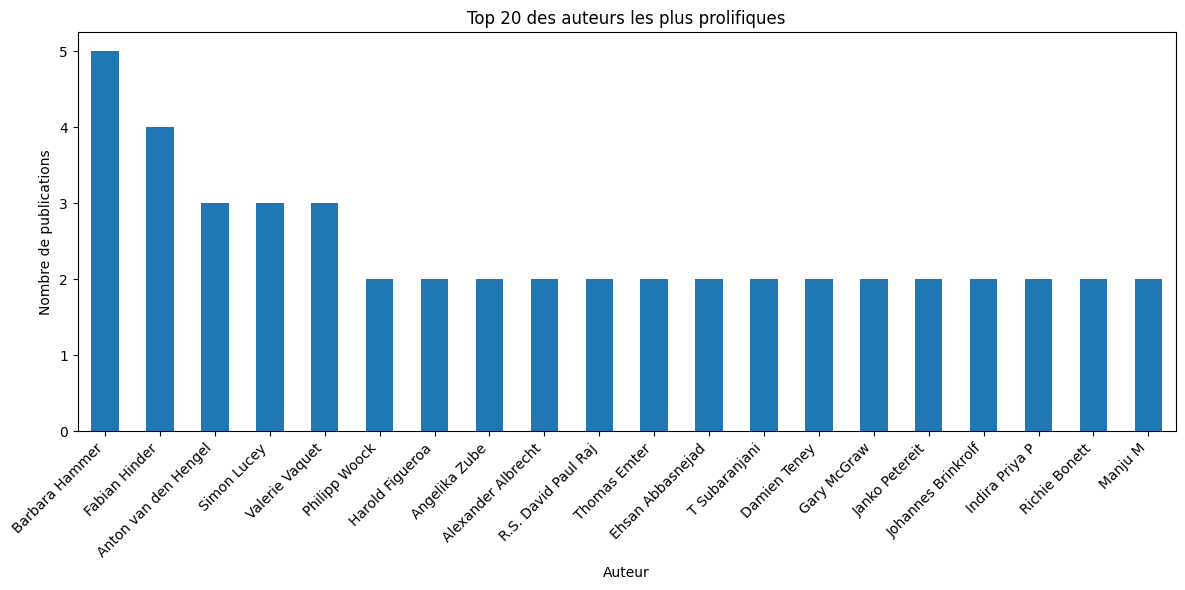

In [127]:
plot_top_authors(df, top_n=20)

In [111]:
plot_keyword_cloud(df)

KeyError: 'keywords'

In [112]:
plot_keyword_evolution(df, top_n=20)

KeyError: 'keywords'

/var/folders/1w/cp3gd6d5749_6bq40_6_35vh0000gn/T/ipykernel_35075/1080613677.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


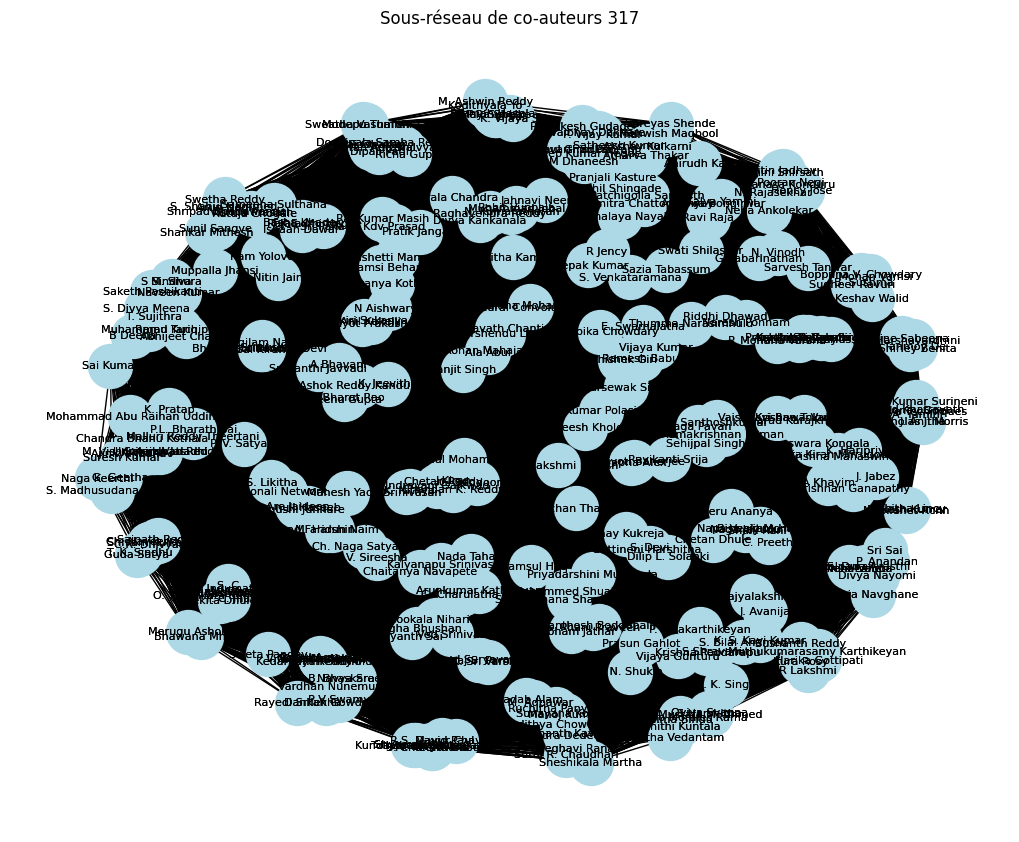

In [113]:
plot_coauthor_networks(df.dropna(subset=['author']))

In [114]:
plot_citation_analysis(df)

Les données de citation ne sont pas disponibles.


/var/folders/1w/cp3gd6d5749_6bq40_6_35vh0000gn/T/ipykernel_35075/2980209882.py:163: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


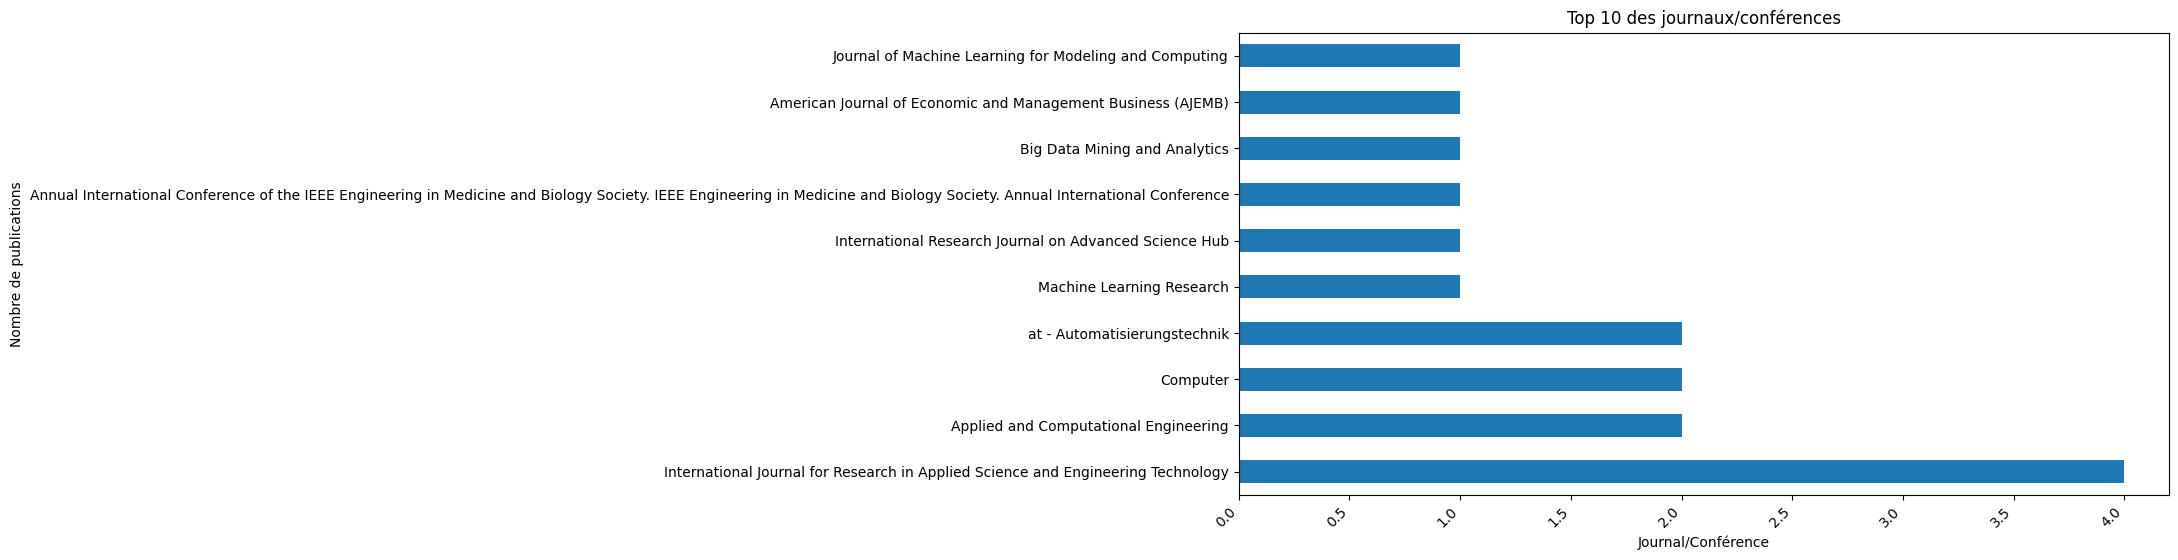

In [130]:
plot_top_venues(df)

IndexError: index 0 is out of bounds for axis 0 with size 0

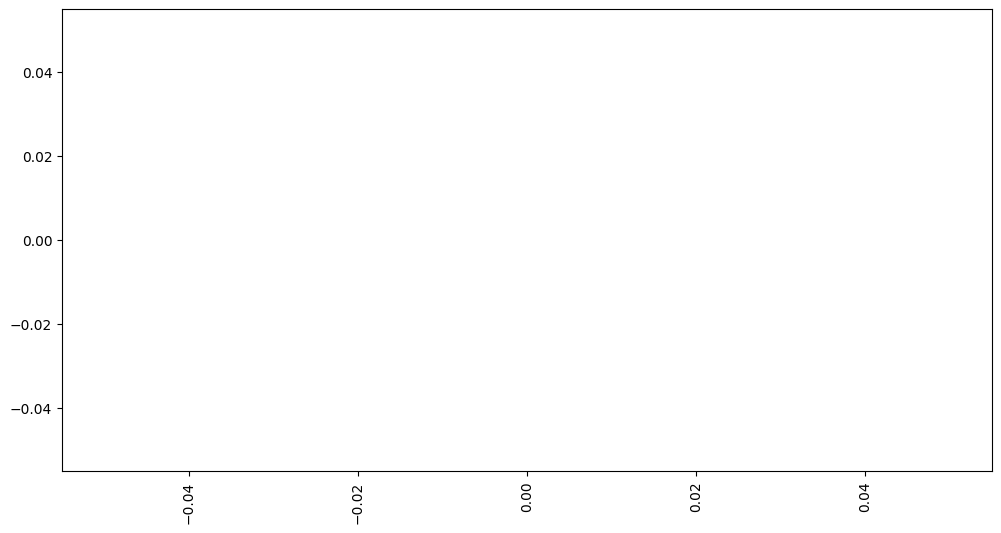

In [135]:
plot_top_bible(df)

In [ ]:
import re

# Path to the .bib file
bib_file_path = 'IEEE Xplore Citation BibTeX Download 2024.6.23.15.2.19.bib'

# Read the content of the .bib file
with open(bib_file_path, 'r') as file:
    bib_content = file.read()

# Regex patterns to extract relevant fields
entry_pattern = re.compile(r'@(\w+)\{([^,]+),')
author_pattern = re.compile(r'author\s*=\s*\{(.+?)\}')
title_pattern = re.compile(r'title\s*=\s*\{(.+?)\}')
year_pattern = re.compile(r'year\s*=\s*\{(\d{4})\}')
abstract_pattern = re.compile(r'abstract\s*=\s*\{(.+?)\}')
doi_pattern = re.compile(r'doi\s*=\s*\{(.+?)\}')

# Extract entries
entries = entry_pattern.findall(bib_content)

# Extract information from each entry
articles = []
for entry in entries:
    entry_type, entry_key = entry
    author_match = author_pattern.search(bib_content)
    title_match = title_pattern.search(bib_content)
    year_match = year_pattern.search(bib_content)
    abstract_match = abstract_pattern.search(bib_content)
    doi_match = doi_pattern.search(bib_content)
    
    author = author_match.group(1) if author_match else 'Unknown Author'
    title = title_match.group(1) if title_match else 'No Title'
    year = year_match.group(1) if year_match else 'No Year'
    abstract = abstract_match.group(1) if abstract_match else 'No Abstract'
    doi = doi_match.group(1) if doi_match else 'No DOI'
    
    # Simplify author to "FirstAuthor et al."
    first_author = author.split(' and ')[0]
    first_author_last_name = first_author.split(',')[0]
    
    articles.append({
        'author': f"{first_author_last_name} et al.",
        'title': title,
        'year': year,
        'abstract': abstract,
        'doi': doi,
        'task': 'TBD',  # To be defined by analyzing the abstract
        'approach': 'TBD',  # To be defined by analyzing the abstract
        'advantage': 'TBD',  # To be defined by analyzing the abstract
        'limitation': 'TBD'  # To be defined by analyzing the abstract
    })

# LaTeX table content
table_content = ""

for article in articles:
    table_content += f"{article['author']}, {article['title']} [{article['year']}] & {article['task']} & {article['approach']} & {article['advantage']} & {article['limitation']} \\\\\n\\hline\n"

# LaTeX document
latex_document = f"""
\\documentclass{{article}}
\\usepackage{{graphicx}}  % Pour \\resizebox
\\usepackage{{longtable}} % Pour les tableaux sur plusieurs pages

\\begin{{document}}

\\resizebox{{\\textwidth}}{{!}}{{
\\begin{{longtable}}{{|p{{4cm}}|p{{3cm}}|p{{3cm}}|p{{3cm}}|p{{3cm}}|}}
\\hline
\\textbf{{Premier auteur et al., titre [année]}} & \\textbf{{Tâche (domaine)}} & \\textbf{{Approche}} & \\textbf{{Avantage}} & \\textbf{{Limite}} \\\\
\\hline
\\endfirsthead
\\multicolumn{{5}}{{c}}%
{{{{\\bfseries \\tablename\\ \\thetable{{}} -- suite de la page précédente}}}} \\\\
\\hline
\\textbf{{Premier auteur et al., titre [année]}} & \\textbf{{Tâche (domaine)}} & \\textbf{{Approche}} & \\textbf{{Avantage}} & \\textbf{{Limite}} \\\\
\\hline
\\endhead
\\hline \\multicolumn{{5}}{{r}}{{{{Suite à la page suivante}}}} \\\\
\\endfoot
\\hline
\\endlastfoot
{table_content}
\\end{{longtable}}
}}
\\end{{document}}
"""

# Write the LaTeX document to a file
latex_file_path = 'table.tex'
with open(latex_file_path, 'w') as file:
    file.write(latex_document)

print(f"LaTeX file saved to: {latex_file_path}")


In [151]:
def plot_domains_props(domains_vector):
    # Données
    print(type(domains_vector))
    domaines = ','.join([(','.join(d.split(';')) if ';' in d else d) for d in domains_vector if isinstance(d, str)])
    domaines = domaines.split(',')
    
    # Calcul automatique des valeurs
    compteur = Counter(domaines)
    domaines_uniques = list(compteur.keys())
    valeurs = list(compteur.values())
    # Trier les domaines par fréquence
    domaines_tries, valeurs_triees = zip(*sorted(zip(domaines_uniques, valeurs), key=lambda x: x[1], reverse=True))
    
    # Création du graphique
    plt.figure(figsize=(12, 8))
    wedges, texts, autotexts = plt.pie(
        valeurs_triees, labels=domaines_tries, autopct='%1.1f%%', startangle=90, pctdistance=0.85
    )
    
    plt.title("Nombre de Domaine de recherche")
    
    # Ajout d'un cercle au centre pour créer l'effet de donut
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    # Espacement des labels
    for i, text in enumerate(texts):
        text.set_horizontalalignment('center')
        x, y = text.get_position()
        angle = wedges[i].theta2 - (wedges[i].theta2 - wedges[i].theta1) / 2
        x += 0.2 * np.cos(np.radians(angle))
        y += 0.2 * np.sin(np.radians(angle))
        text.set_position((x, y))
        
        # Ajouter une flèche
        plt.annotate(
            text.get_text(), 
            xy=(x, y), 
            xytext=(1.4*x, 1.4*y),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2")
        )
        text.set_text("")
    
    # Ajustement de la mise en page
    plt.tight_layout()
    plt.savefig('domains.png')
    # Affichage du graphique
    plt.show()
    return domaines

In [136]:
df = pd.read_csv("ML-export24.csv", index_col=0)

In [137]:
df.head()

,Title,Date Published,Publication Year,Publication Type,Source Title,ISSNs,Publisher,Source Country,Author/s,Abstract,...,PMID,DOI,Microsoft Academic ID,PMCID,Citing Patents Count,References,Citing Works Count,Is Open Access,Open Access License,Open Access Colour
Lens ID,,,,,,,,,,,,,,,,,,,,,
002-070-783-106-14X,Curvature-Aware Training for Coordinate Networks,2023-10-01,2023,conference proceedings article,2023 IEEE/CVF International Conference on Comp...,NaN,IEEE,NaN,Hemanth Saratchandran; Shin-Fang Chng; Sameera...,Coordinate networks are widely used in compute...,...,NaN,10.1109/iccv51070.2023.01226,NaN,NaN,0,007-716-735-483-006; 025-791-818-194-480; 027-...,0,False,NaN,NaN
004-951-530-050-400,Models and algorithms of privacy-preserving ma...,2020-03-13,2020,journal article,Bezopasnost informacionnyh tehnology,20747136; 20747128,National Research Nuclear University MEPhI (Mo...,NaN,Sergey Zapechnikov,The paper is devoted to the recent scientific ...,...,NaN,10.26583/bit.2020.1.05,3012205321,NaN,0,001-455-896-359-494; 002-781-648-163-978; 007-...,3,True,cc-by,gold
006-610-516-419-74X,Accelerator-Aware Training for Transducer-Base...,2023-01-09,2023,conference proceedings article,2022 IEEE Spoken Language Technology Workshop ...,NaN,IEEE,NaN,Suhaila M. Shakiah; Rupak Vignesh Swaminathan;...,Machine learning model weights and activations...,...,NaN,10.1109/slt54892.2023.10022592,NaN,NaN,0,009-169-455-709-27X; 011-984-183-663-740; 019-...,0,True,NaN,green
006-932-788-992-090,Machine learning and artificial intelligence i...,NaN,2023,journal article,Sustainable Manufacturing and Service Economics,26673444,Elsevier BV,NaN,Mohsen Soori; Behrooz Arezoo; Roza Dastres,Artificial Intelligence (AI) and Machine learn...,...,NaN,10.1016/j.smse.2023.100009,NaN,NaN,0,002-131-812-574-61X; 002-159-646-316-264; 004-...,28,True,"CC BY, CC BY-NC-ND",gold
013-504-215-188-823,CoD: Coherent Detection of Entities from Image...,2024-01-03,2024,conference proceedings article,2024 IEEE/CVF Winter Conference on Application...,NaN,IEEE,NaN,Vinay Verma; Dween Sanny; Abhishek Singh; Deep...,NaN,...,NaN,10.1109/wacv57701.2024.00783,NaN,NaN,0,001-236-893-632-918; 014-346-638-217-687; 017-...,0,False,NaN,NaN


<class 'list'>


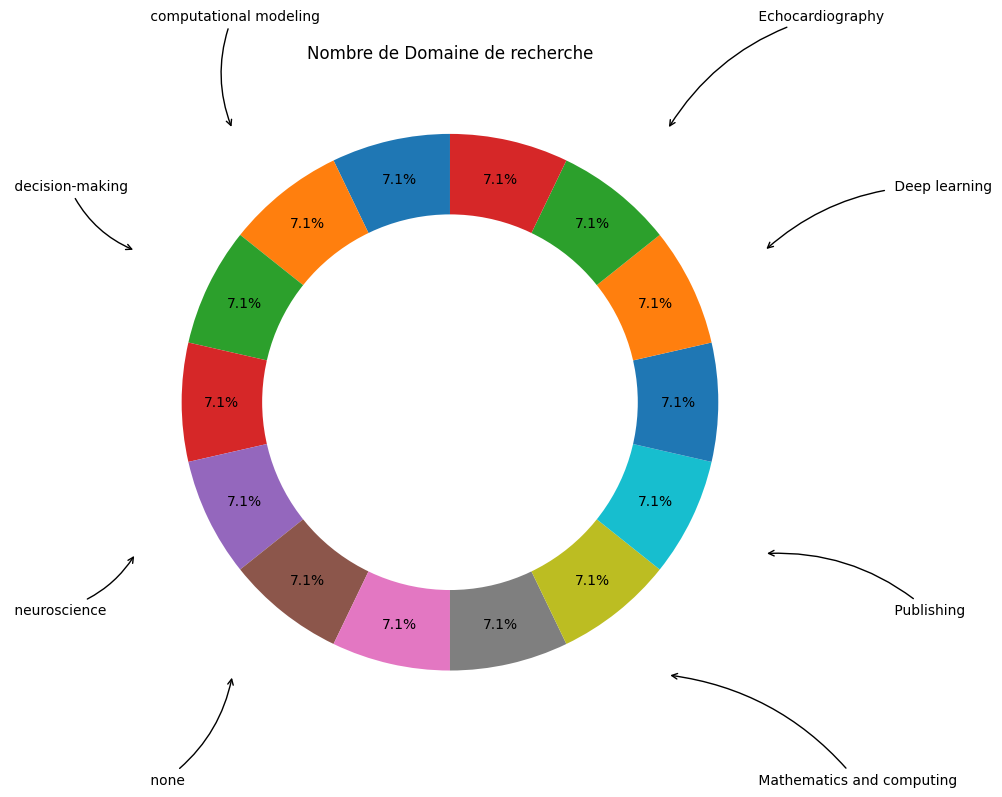

In [154]:
domaines = plot_domains_props(list(df['Keywords'].values))

In [89]:
def plot_domains_props_1(domains_vector):
    # Compter les occurrences de chaque domaine
    compteur = Counter(domains_vector)
    domaines_uniques = list(compteur.keys())
    valeurs = list(compteur.values())
    
    # Trier les domaines par fréquence
    domaines_tries, valeurs_triees = zip(*sorted(zip(domaines_uniques, valeurs), key=lambda x: x[1], reverse=True))
    
    # Création du graphique
    fig, ax = plt.subplots(figsize=(10, 7))
    wedges, texts, autotexts = ax.pie(valeurs_triees, labels=domaines_tries, autopct='%1.1f%%', startangle=90, textprops=dict(color="w"))
    
    # Ajout de commentaires et espacement
    for text in texts:
        text.set_fontsize(10)
    for autotext in autotexts:
        autotext.set_fontsize(8)
        autotext.set_color('black')
    
    # Ajout de flèches pour les annotations
    for i, (pct, label) in enumerate(zip(autotexts, textes)):
        x = pct.get_position()[0]
        y = pct.get_position()[1]
        ax.annotate(
            f"{label.get_text()} ({pct.get_text()})",
            xy=(x, y), xytext=(x*1.2, y*1.2),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"),
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.7),
            fontsize=10,
            ha='center'
        )
    
    # Titre et ajustement de la mise en page
    plt.title("Nombre de Domaines de Recherche")
    plt.tight_layout()
    plt.savefig('domains.png')
    plt.show()

NameError: name 'textes' is not defined

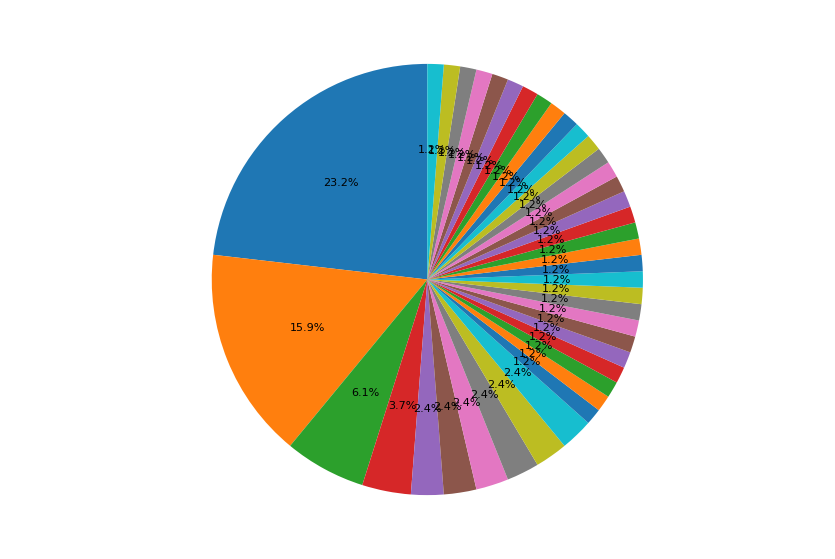

In [93]:
plot_domains_props_1(domaines)

In [153]:
domaines

['Computer science',
 ' Training (meteorology)',
 ' Coordinate system',
 ' Modalities',
 ' Artificial intelligence',
 ' Voxel',
 ' Computer vision',
 ' Artificial neural network',
 ' Curvature',
 ' SIGNAL (programming language)',
 ' Mathematics',
 ' Social science',
 ' Physics',
 ' Geometry',
 ' Sociology',
 ' Meteorology',
 ' Programming language',
 'Machine learning',
 ' Computer security model',
 ' Artificial intelligence',
 ' Cryptographic primitive',
 ' Cryptography',
 ' Test (assessment)',
 ' Privacy preserving',
 ' Field (computer science)',
 ' Computer science',
 ' Adversary',
 ' Process (engineering)',
 'Computer science',
 ' Inference',
 ' Artificial neural network',
 ' Latency (audio)',
 ' Leverage (statistics)',
 ' Speech recognition',
 ' Quantization (signal processing)',
 ' Recurrent neural network',
 ' Artificial intelligence',
 ' Computer vision',
 ' Telecommunications',
 'Machining',
 ' Machine learning',
 ' Artificial intelligence',
 ' Numerical control',
 ' Machine t

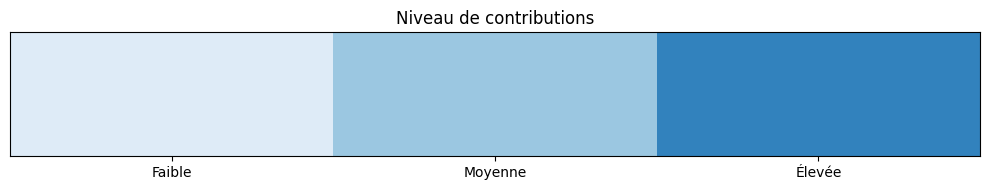

In [121]:
fig, ax = plt.subplots(figsize=(10, 2))

# Couleurs ajustées pour mieux correspondre à la carte
colors = ['#deebf7', '#9bc7e1', '#3282bd']

for i, color in enumerate(colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, facecolor=color))

ax.set_xlim(0, 3)
ax.set_ylim(0, 1)
ax.set_xticks([0.5, 1.5, 2.5])  # Centrer les étiquettes sous chaque rectangle
ax.set_xticklabels(['Faible', 'Moyenne', 'Élevée'])
ax.set_yticks([])

ax.set_title("Niveau de contributions")

plt.tight_layout()
plt.savefig('legende_contributions_ajustee.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/1w/cp3gd6d5749_6bq40_6_35vh0000gn/T/ipykernel_2058/2214660104.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


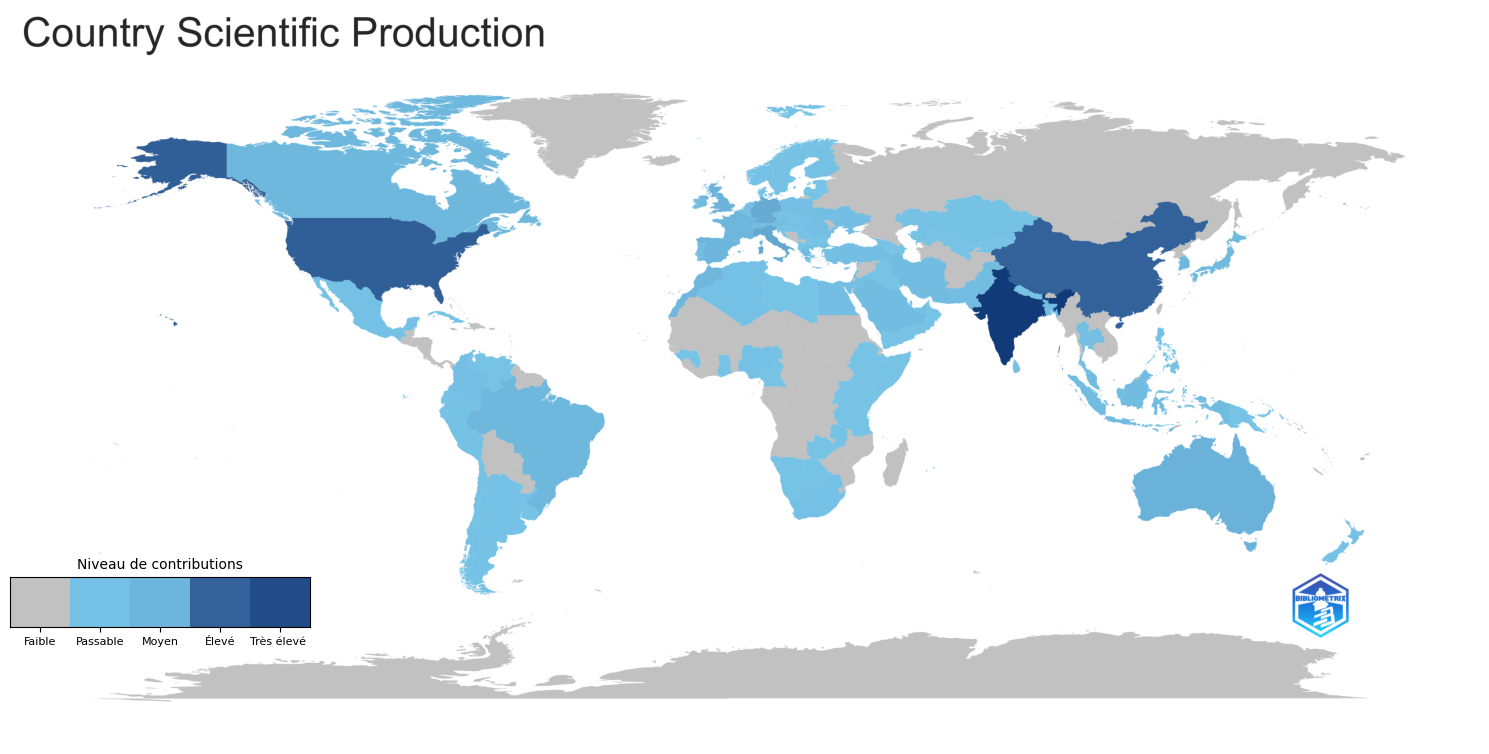

In [3]:
from matplotlib.patches import Rectangle

# Charger l'image de la carte
img = plt.imread('CountryScientificProduction-2024-07-30.png')

# Créer la figure et les axes
fig, ax = plt.subplots(figsize=(15, 10))

# Afficher la carte
ax.imshow(img)
ax.axis('off')
# Fonction pour créer la légende
def create_legend(parent_ax):
    # Créer un nouvel axe pour la légende
    legend_ax = fig.add_axes([0.01, 0.25, 0.2, 0.05])  # [x, y, largeur, hauteur]

    colors = ['#c1c1c1', '#75c1e5', '#6db5db', '#33629b', '#214c88']
    for i, color in enumerate(colors):
        legend_ax.add_patch(Rectangle((i, 0), 1, 1, facecolor=color))

    legend_ax.set_xlim(0, 5)
    legend_ax.set_ylim(0, 1)
    legend_ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
    legend_ax.set_xticklabels(['Faible', 'Passable', 'Moyen', 'Élevé', 'Très élevé '], fontsize=8)
    legend_ax.set_yticks([])
    legend_ax.set_title("Niveau de contributions", fontsize=10)
    legend_ax.axis('on')

# Ajouter la légende
create_legend(ax)

# Ajuster la mise en page
plt.tight_layout()

# Sauvegarder l'image
plt.savefig('cart1.png', dpi=300, bbox_inches='tight')

# Afficher la figure
plt.show()

In [ ]:
# Data for the graphs
categories = [
    "Vision par ordinateur",
    "Traitement du langage naturel",
    "Sécurité informatique",
    "Robotique",
    "Santé",
    "Data-Driven Architectures",
    "Architectures pour les Systèmes Embarqués et IoT",
    "DevOps et Intégration Continue",
    "Architecture Orientée Services (SOA) et Cloud Computing",
    "Ethique et Pratiques Responsables"
]

subject_1_relevance = [0, 0, 0, 1, 0, 1, 1, 0, 0, 0]
subject_2_relevance = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
subject_3_relevance = [1, 1, 0, 1, 0, 0, 0, 0, 0, 0]

# Create a stacked bar plot
fig, ax = plt.subplots(figsize=(15, 8))

ax.bar(categories, subject_1_relevance, label="Apprentissage automatique pour la génération d'images médicales volumétriques à des fins de diagnostic de maladie", color='skyblue')
ax.bar(categories, subject_2_relevance, bottom=subject_1_relevance, label="Extraction automatique des caractéristiques à partir des matrices géopolymères pour la corrélation porosité-hygroscopie", color='lightgreen')
ax.bar(categories, subject_3_relevance, bottom=np.add(subject_1_relevance, subject_2_relevance), label="Prediction du risque de credit bancaire sensible aux coûts financiers en intégrant des descripteurs extraits des graphes", color='salmon')

# Setting the labels
ax.set_xlabel('Research Axes')
ax.set_ylabel('Relevance')
ax.set_title('Cumulative Relevance of Research Subjects to Various Research Axes')
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_ylim(0, 3)
ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()
